# Introduction to TPI tool for the processing of MODIS data

* **Compatability:** Notebook currently compatible with the `NCI` environment
* **Products used:** `modis_oc_1d development` database
* **Requirements:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set: 
```
module use /g/data/v10/public/modules/modulefiles;
module load dea
```    
* **Prerequisites:** The [introduction_to_MODIS_oceancolor](./introduction_to_modis_oceancolour.ipynb) notebook

## Background

The Australian Government has established 60 marine parks around the country. Marine parks help conserve marine habitats and the marine species that live within and rely on these habitats. Marine parks also provide places for people to watch wildlife, dive, and go boating, snorkelling and fishing. Importantly, they create jobs in industries like fishing and tourism, and provide us with food and energy.

Understanding and monitoring the environmental characteristics of Australian marine parks can be challenging due to their remoteness and large sizes. Marine surveys and in-situ observation instruments can provide some environmental information, however these are often very expensive and lack spatial and/or temporal coverage.

### Digitial Earth Australia use case

Imagery from satellites such as [NASA's MODIS](https://terra.nasa.gov/about/terra-instruments/modis) and [NOAA's AVHRR](https://www.ospo.noaa.gov/Operations/POES/NOAA15/avhrr.html) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring Australian marine parks. 

Satellite data can provide envrionmental information on water quality, sea surface temperature and primary productivity of Australian marine parks in a timely manner. Satellite data can also help detect and monitor harmful events such as algae blooms and marine heat waves occuring in Australian marine parks.

## Description

In this example, we calculate TPI (Topographic Poistion Index) [(Weiss, 2001)](#References) to identify local spatial anomalies of [IMOS](http://imos.org.au/) MODIS SST (Sea Surface Temperature) and CHL (Chlorophyll-a) data. The worked example demonstrates how to:

1. Load in MODIS SST and CHL data for the Bonney Coast upwelling area
2. Merge the data every 5 days to fill the data gap
3. Define a TPI function
4. Calculate TPI from the SST and CHL data
5. Plot the TPI images to examine the Bonney Coast upwelling characteristics

## Getting started

To run this analysis, run all the cells in the notebook, starting with the [Load packages](#LoadPackages) cell.
    
After finishing the analysis, return to the [Analysis parameters](#AnalysisParameters) cell, modify some values (e.g. choose a different output crs or resolution or a different marine park) and re-run the analysis.

<a id='LoadPackages'></a>
## Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline
import geopandas as gpd
from datacube import Datacube
import datacube

from datacube.storage.masking import mask_invalid_data
from datetime import datetime
from skimage.morphology import disk
import numpy as np
import xarray as xr
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

Note that `modis_oc_1d` is development product. It is on a different database server `agdcstaging-db.nci.org.au`, which means that your ~/.pgpass file will need to specify a password to connect to it as well.

In [2]:
config = {'db_hostname': 'agdcstaging-db.nci.org.au',
          'db_port': 6432,
          'db_database': 'dea_modis'}

dc = Datacube(config=config)

<a id='AnalysisParameters'></a>
### Analysis parameters
    
The following cell set important parameters for the analysis:
  
* `lat`: The latitude dimension (e.g., `(0, -40)`).
* `lon`: The longitude dimension (e.g., `(100, 160)`).
* `time`: The time dimension (e.g., `('2016-01-01', '2016-01-15')`).
* `resolution`: The desirable spatial resolution of the MODIS CHL data in decimal degrees (e.g., `(-0.1, 0.1)`). If the resolution is not the inherited resolution of the products,the retrived data will be resampled.
* `measurements`: The MODIS variables to load (e.g., `('sst', 'chl_gsm')`).
* `Australia_path` : path to location of a shapefile of Australia mainland used for plotting.

In [3]:
lat = (-30,-40)
lon = (130,150)
time = ('2016-01-01','2016-01-15')
resolution = (-0.01, 0.01)
measurements = ('sst', 'chl_gsm')
Australia_path = '../../shapefiles/mainlands_100k.shp'

## Build query and load data

We will calculate the time taken to load the data as well.

In [4]:
# define query
query = {'lat': lat,
         'lon': lon,
        'time': time,
        'resolution': resolution,
        'measurements': measurements}

In [5]:
time1 = datetime.now()
MODIS_data = dc.load(product='modis_oc_1d', **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:00:09.647595 to finish


#### Mask the nodata (-999) as 'nan'

In [6]:
MODIS_data_clean = mask_invalid_data(MODIS_data)


### Reset the CHL values > 5.0 mg/m<sup>3</sup> to 5.0 mg/m<sup>3</sup>
The chl values greater than 5.0 mg/m<sup>3</sup> are likely over-estimated; these values are reset to 5.0 mg/m<sup>3</sup>

In [7]:
# round the CHL value > 5.0 to 5.0
MODIS_data_clean['chl_gsm_corr'] = MODIS_data_clean.chl_gsm.clip(min=0, max=5)

In [8]:
MODIS_data_clean

<xarray.Dataset>
Dimensions:       (latitude: 1000, longitude: 2000, time: 15)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-01T11:59:59.999999 ... 2016-01-15T11:59:59.999999
  * latitude      (latitude) float64 -30.0 -30.02 -30.02 ... -39.98 -39.99
  * longitude     (longitude) float64 130.0 130.0 130.0 ... 150.0 150.0 150.0
Data variables:
    sst           (time, latitude, longitude) float32 nan nan nan ... nan nan
    chl_gsm       (time, latitude, longitude) float32 nan nan nan ... nan nan
    chl_gsm_corr  (time, latitude, longitude) float32 nan nan nan ... nan nan
Attributes:
    crs:      EPSG:4326

### A quick plot of a CHL image

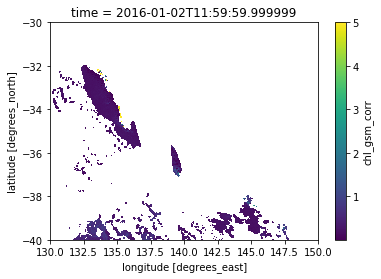

In [9]:
MODIS_data_clean.chl_gsm_corr[1].plot()

### Merge the data together every 5 days to fill in the gaps caused by clouds coverage

In [10]:
MODIS_data_clean5D = MODIS_data_clean.resample(time='5D').mean()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [11]:
MODIS_data_clean5D

<xarray.Dataset>
Dimensions:       (latitude: 1000, longitude: 2000, time: 3)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-01 2016-01-06 2016-01-11
  * latitude      (latitude) float64 -30.0 -30.02 -30.02 ... -39.98 -39.99
  * longitude     (longitude) float64 130.0 130.0 130.0 ... 150.0 150.0 150.0
Data variables:
    sst           (time, latitude, longitude) float32 nan nan ... 19.98 19.99
    chl_gsm       (time, latitude, longitude) float32 nan nan ... 0.22132924
    chl_gsm_corr  (time, latitude, longitude) float32 nan nan ... 0.22132924

### Plot the 5-days composites

<Figure size 1080x1080 with 0 Axes>

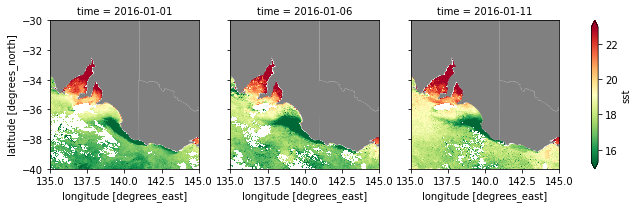

In [12]:
plt.figure(figsize=(15,15))
grid = MODIS_data_clean5D.sst.plot.imshow(col='time',
                     col_wrap=3,
                     cmap='RdYlGn_r',
                     robust=True,    # the robust option remove outliers from displaying to enhance the image contrast                 
                     add_labels=False)
# plot shapefile in each subplot
for ax in grid.axes.flatten():
    ax.set_xlim(left=135,right=145)
    ax.set_ylim(bottom=-40,top=-30)
    shape_plot = gpd.read_file(Australia_path)
    shape_plot.plot(color='gray',ax=ax)


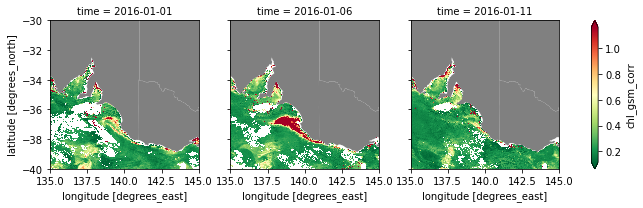

In [13]:
grid = MODIS_data_clean5D.chl_gsm_corr.plot.imshow(col='time',
                     col_wrap=3,
                     cmap='RdYlGn_r',
                     robust=True,                              
                     add_labels=False)
# plot shapefile in each subplot
for ax in grid.axes.flatten():
    ax.set_xlim(left=135,right=145)
    ax.set_ylim(bottom=-40,top=-30)
    shape_plot = gpd.read_file(Australia_path)
    shape_plot.plot(color='gray',ax=ax)


## Define a function to calculate TPI

In [14]:
def my_mean_filter(data):
    """
    A custom spatial filter to calculate spatial mean of a input data array
     (or a raster dataset). This custom filter is used as a input to 'ndimage.generic_filter' 
     method. This is used in the 'calculate_tpi' method defined below.    

     
     Last modified: June 2020
     Author: Zhi Huang
     
     : param data:
         Input array-like data. 

     : return:
         Output the mean value for the input array, nodata has been ignored
     """


    return np.nanmean(data)
    

In [15]:
def calculte_tpi(data,neighborhood='Rectangle',size=[3,3],radius=3):
    """
    Calculate topographic position index (TPI) (Weiss, 2001) for a raster dataset.
    TPI is a local spatial statistic. It requires specifications of a neighborhood shape
     and size. The current method allows only two neighborhood shapes: Rectangle and Circle.
    The method calls the 'ndimage.generic_filter' method to calculate local (focal) mean 
    within the specified neighborhood using the 'my_mean_filter' method defined above, similar 
    to ArcGIS' 'focal statistics' tool. Note that the unit for the neighborhood size is the 
    same as that indicated by the coordinate system of the input data. 
    
    Last modified: June 2020
    Author: Zhi Huang
    
    :param data:
        Input data array. Must be a xarray.DataArray.
    :param neighborhood:
        A text string specify the neighborhood shape. Currently, only two values are allowed: 
        'Rectangle' and 'Circle'.
    :param size:
        This parameter specifies the size of the 'Rectangle' neighborhood. The value must be a 
        list in the form of [width,height], where width is the width of the rectangle' and height 
        is the height of the rectangle. If not specified, the default value is [3,3], indicating 
        a 3 by 3 square window.
    :param radius:
        This parameter specifies the size of the 'Circle' neighborhood. The value must a integer value 
        specifying the radius of the circle. If not specified, the default value is 3.
      
    :return:
        Output xarray.DataArray
        
    """
    
    if neighborhood == 'Rectangle':
        width = size[0]
        height = size[1]
        footprint = np.ones(width*height).reshape(height,width)
        
    elif neighborhood == 'Circle':
        footprint = disk(radius)
        

    mean_filter = lambda x: generic_filter(x,my_mean_filter,footprint=footprint)
    data_mean = xr.apply_ufunc(mean_filter,data)
  
    return data - data_mean

## Calculate TPI from the SST and CHL data
First need to create two empty data array to hold the results

In [16]:
x = np.empty((MODIS_data_clean5D.time.size,MODIS_data_clean5D.latitude.size,MODIS_data_clean5D.longitude.size))

x[:] = np.nan

y = np.empty((MODIS_data_clean5D.time.size,MODIS_data_clean5D.latitude.size,MODIS_data_clean5D.longitude.size))

y[:] = np.nan

# Create an empty dataset to put our values into
MODIS_data_clean5D['sst_tpi'] = xr.DataArray(data=x,
                                       coords={
                                           'time': MODIS_data_clean5D['time'],
                                           'latitude': MODIS_data_clean5D['latitude'],
                                           'longitude': MODIS_data_clean5D['longitude']
                                       },
                                               dims=['time','latitude','longitude'])

MODIS_data_clean5D['chl_tpi'] = xr.DataArray(data=y,
                                       coords={
                                           'time': MODIS_data_clean5D['time'],
                                           'latitude': MODIS_data_clean5D['latitude'],
                                           'longitude': MODIS_data_clean5D['longitude']
                                       },
                                               dims=['time','latitude','longitude'])


In [17]:
time1 = datetime.now()
for iix, i in enumerate(MODIS_data_clean5D.time):
    MODIS_data_clean5D['sst_tpi'][iix] = calculte_tpi(MODIS_data_clean5D.isel(time=iix).sst,neighborhood='Circle',radius=50)
    MODIS_data_clean5D['chl_tpi'][iix] = calculte_tpi(MODIS_data_clean5D.isel(time=iix).chl_gsm_corr,neighborhood='Circle',radius=50)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


took 0:25:54.472911 to finish


In [18]:
MODIS_data_clean5D

<xarray.Dataset>
Dimensions:       (latitude: 1000, longitude: 2000, time: 3)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-01 2016-01-06 2016-01-11
  * latitude      (latitude) float64 -30.0 -30.02 -30.02 ... -39.98 -39.99
  * longitude     (longitude) float64 130.0 130.0 130.0 ... 150.0 150.0 150.0
Data variables:
    sst           (time, latitude, longitude) float32 nan nan ... 19.98 19.99
    chl_gsm       (time, latitude, longitude) float32 nan nan ... 0.22132924
    chl_gsm_corr  (time, latitude, longitude) float32 nan nan ... 0.22132924
    sst_tpi       (time, latitude, longitude) float64 nan nan ... -0.4689
    chl_tpi       (time, latitude, longitude) float64 nan nan ... 0.01703

## Plot the TPI images

<Figure size 1080x1080 with 0 Axes>

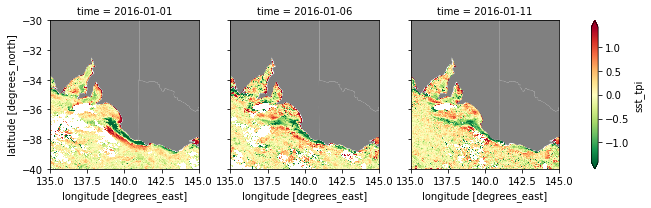

In [19]:
plt.figure(figsize=(15,15))
grid = MODIS_data_clean5D.sst_tpi.plot.imshow(col='time',
                     col_wrap=3,
                     cmap='RdYlGn_r',
                     robust = True,
                     add_labels=False)
# plot shapefile in each subplot
for ax in grid.axes.flatten():
    ax.set_xlim(left=135,right=145)
    ax.set_ylim(bottom=-40,top=-30)
    shape_plot = gpd.read_file(Australia_path)
    shape_plot.plot(color='gray',ax=ax)

<Figure size 1080x1080 with 0 Axes>

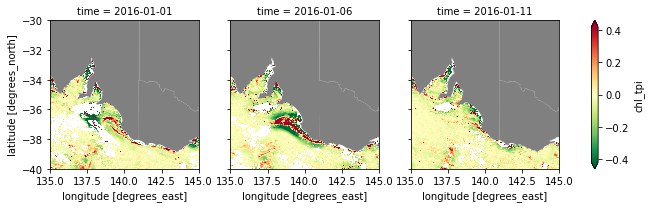

In [20]:
plt.figure(figsize=(15,15))
grid = MODIS_data_clean5D.chl_tpi.plot.imshow(col='time',
                     col_wrap=3,
                     cmap='RdYlGn_r',
                     robust=True,
                     add_labels=False)
# plot shapefile in each subplot
for ax in grid.axes.flatten():
    ax.set_xlim(left=135,right=145)
    ax.set_ylim(bottom=-40,top=-30)
    shape_plot = gpd.read_file(Australia_path)
    shape_plot.plot(color='gray',ax=ax)

### Plot the SST data and the TPI layer derived from it for comparison

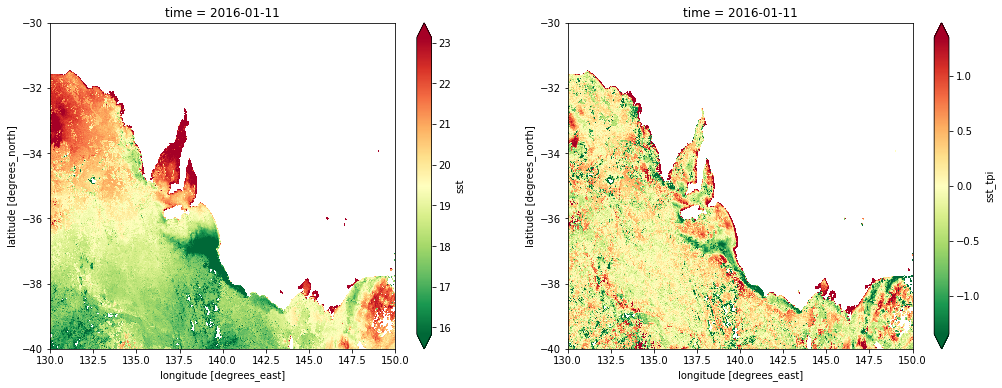

In [21]:
f, axes = plt.subplots(1,2,figsize=(17,6))
MODIS_data_clean5D['sst'][2].plot(cmap='RdYlGn_r',robust=True,ax=axes[0])
MODIS_data_clean5D['sst_tpi'][2].plot(cmap='RdYlGn_r',robust=True,ax=axes[1])

### Plot the CHL data and the TPI layer derived from it for comparison

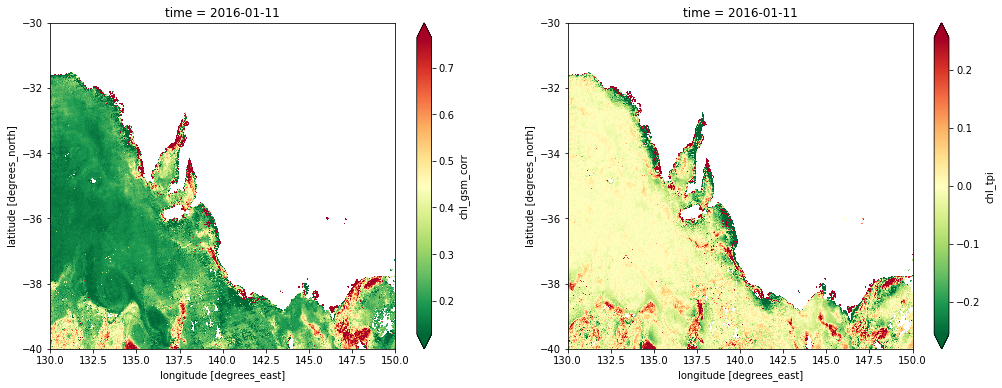

In [22]:
f, axes = plt.subplots(1,2,figsize=(17,6))
MODIS_data_clean5D['chl_gsm_corr'][2].plot(cmap='RdYlGn_r',robust=True,ax=axes[0])
MODIS_data_clean5D['chl_tpi'][2].plot(cmap='RdYlGn_r',robust=True,ax=axes[1])

<a id='References'></a>
## References
Weiss, A.D. (2001). Topographic Position and Landforms Analysis. In, ESRI International User Conference. San Diego, CA

## Additional information
    
**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.
  
**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).
 
**Last modified:** June 2020
   
**Compatible datacube version:** 

In [24]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags

Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)